# Import important libraries

In [1]:
import pandas as pd
import numpy as np
import re
import html
from bs4 import BeautifulSoup
from nltk.tokenize import RegexpTokenizer
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import  Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold,GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier 
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from gensim.models import word2vec
import collections


import warnings
warnings.filterwarnings("ignore")

ModuleNotFoundError: No module named 'wordcloud'

# Read csv file to dataframe

In [0]:
tweet_sentiment = pd.read_csv("Sentiment.csv")

In [4]:
tweet_sentiment

,sentiment,text
0,Positive,RT @Diplomtc_Immnty: @realDonaldTrump They tri...
1,Negative,"@chiefy74 Damn i'm jealous, i wanna watch the ..."
2,Positive,I'm listening The Beatles now. They're great
3,Positive,@ddlovato could i please get a shout out or an...
4,Positive,@salspizza just spotted ur message there Tony ...
...,...,...
133806,Positive,"@scottw Nice, I have the 20/20 but to be hones..."
133807,Positive,â€œ@BW_React: #GOPDebate verdict: @JohnKasich ...
133808,Negative,@amtrack i am sorry .... i love you tho and t...
133809,Positive,@RazorTV http://tinyurl.com/d96txo - Champions...


In [0]:
CA_elections = pd.read_csv("Canadian_elections_2019.csv", dtype = {'text': bytes})

In [6]:
CA_elections

,sentiment,negative_reason,text
0,Negative,Women Reproductive right and Racism,"b""@RosieBarton So instead of your suggestion, ..."
1,Positive,NaN,"b""#AllWomanSpacewalk it's real!\n@Space_Statio..."
2,Negative,Economy,"b""#Brantford It's going to cost YOU $94 BILLIO..."
3,Positive,NaN,"b""#Canada #CanadaElection2019 #CanadaVotes \n#..."
4,Negative,Economy,"b""#Canada #taxpayers are sick &amp; tired of h..."
...,...,...,...
2128,Negative,Scandal,b'You know he was doing a good enough job smea...
2129,Negative,Scandal,b'You missed the comment. Deflecting the issue...
2130,Positive,NaN,b'Your daily reminder:\n@theJagmeetSingh endor...
2131,Negative,Women Reproductive right and Racism,b'Yup...not going to reopen the abortion debat...


As we can see above, the CA_election data was in a byte format. I will first convert the byte format into string format and then do the data cleaning.

In [0]:
def byte_to_str(tweet):
    tweet = eval(tweet).decode("utf-8", "ignore")
    return tweet

In [8]:
CA_elections['text'] = CA_elections['text'].apply(lambda x: byte_to_str(x))
CA_elections

,sentiment,negative_reason,text
0,Negative,Women Reproductive right and Racism,"@RosieBarton So instead of your suggestion, ho..."
1,Positive,NaN,#AllWomanSpacewalk it's real!\n@Space_Station ...
2,Negative,Economy,#Brantford It's going to cost YOU $94 BILLION ...
3,Positive,NaN,#Canada #CanadaElection2019 #CanadaVotes \n#el...
4,Negative,Economy,#Canada #taxpayers are sick &amp; tired of hav...
...,...,...,...
2128,Negative,Scandal,You know he was doing a good enough job smeari...
2129,Negative,Scandal,You missed the comment. Deflecting the issue d...
2130,Positive,NaN,Your daily reminder:\n@theJagmeetSingh endorse...
2131,Negative,Women Reproductive right and Racism,Yup...not going to reopen the abortion debate....


# 1. Data Cleaning

Now we have our dataset ready, but as they are collected directly from the web, they contains html tags, urls and etc. Therefore, the first step we do is to clean the data and convert them into a model readable format. The following are the requirements of the data cleaning process:
*   All html tags and attributes (i.e., /<[^>]+>/) are removed.
*   Html character codes (i.e., &...;) are replaced with an ASCII equivalent.
*   All URLs are removed.
*   All characters in the text are in lowercase.
*   All stop words are removed. Be clear in what you consider as a stop word.
*   If a tweet is empty after pre-processing, it should be preserved as such.

<p>Here I defined a function to do the data cleaning, and defined the stopwords from the txt file provided in this assignment. 

In [0]:
def DataPreprocessing(tweet):
    tokenizer = RegexpTokenizer(r'\w+')
    ps = PorterStemmer()

    # removing HTML tags and attributes
    tweet = re.sub(r'<[^>]+>', '', tweet)  

    # converting HTML character codes into their ASCII Equivalent
    tweet = html.unescape(tweet)

    # Remove tags and mentioned
    #the first group removes @-references to others, 
    #the second group removes all non-alphanumerics except space and tab (and now colon) 
    #and the last group remove internet addresses and the like (e.g. staring at "http://" or "file://" or similar).
    tweet = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t:])|(\w+:\/\/\S+)", " ", tweet).split())
    
    # removing '\n' from tweets since there are a lot of \n in the election data
    tweet = tweet.replace('\n', '')

    # converting text into lowercase
    tweet = tweet.lower()

    
    # tokenize the tweet and remove all the stopwords
    tweet = tokenizer.tokenize(tweet)
    tweet = [word for word in tweet if word not in stop_words]

    # stem each word in tweet and join the stemmed words in to one tweet
    tweet = [ps.stem(word) for word in tweet] 
    tweet = " ".join(tweet)

    return tweet

In [0]:
stop_words = open('stop_words.txt','r').read()

### a. Apply data cleaning function to generic tweet sentiment dataframe.

In [0]:
tweet_sentiment = tweet_sentiment[tweet_sentiment['text'].notnull()]

In [12]:
tweet_sentiment['text_clean'] = tweet_sentiment['text'].apply(lambda x: DataPreprocessing(x))
tweet_sentiment.head()

,sentiment,text,text_clean
0,Positive,RT @Diplomtc_Immnty: @realDonaldTrump They tri...,immnti poll number skyrocket voter matter moder
1,Negative,"@chiefy74 Damn i'm jealous, i wanna watch the ...",damn jealou wanna watch fight love ufc
2,Positive,I'm listening The Beatles now. They're great,listen beatl great
3,Positive,@ddlovato could i please get a shout out or an...,shout huge fan wait cd
4,Positive,@salspizza just spotted ur message there Tony ...,spot messag toni repli


Now our generic tweet has an extra column called "text_clean" which contains the cleaned and stemmed tweet words.

### b. Apply data cleaning function to CA election dataframe

In [13]:
CA_elections['text_clean'] = CA_elections['text'].apply(lambda x: DataPreprocessing(x))
CA_elections

,sentiment,negative_reason,text,text_clean
0,Negative,Women Reproductive right and Racism,"@RosieBarton So instead of your suggestion, ho...",suggest agre canadian women trust andrewsch co...
1,Positive,NaN,#AllWomanSpacewalk it's real!\n@Space_Station ...,allwomanspacewalk station etobicokenorth cityo...
2,Negative,Economy,#Brantford It's going to cost YOU $94 BILLION ...,brantford go cost 94 billion 4 year justin elx...
3,Positive,NaN,#Canada #CanadaElection2019 #CanadaVotes \n#el...,canada canadaelection2019 canadavot elxn43 dec...
4,Negative,Economy,#Canada #taxpayers are sick &amp; tired of hav...,canada taxpay sick tire earn donat corpor welf...
...,...,...,...,...
2128,Negative,Scandal,You know he was doing a good enough job smeari...,good job smear campaign cdnpoli elxn43 bernier...
2129,Negative,Scandal,You missed the comment. Deflecting the issue d...,miss comment deflect issu answer best respons ...
2130,Positive,NaN,Your daily reminder:\n@theJagmeetSingh endorse...,daili remind endors strateg vote elxn43 elxn20...
2131,Negative,Women Reproductive right and Racism,Yup...not going to reopen the abortion debate....,yup go reopen abort debat elxn43 scheerli sche...


The CA Election dataset's text_clean columns contains lower cased, urls and etc removed, and stemmed tweet content as well.

# 2. Exploratory analysis

After the data cleanning step, we will explore the dataset and visualize the data and provide some insights.
<p>First of all we will add two columns, one is the Mentioned column, and the other one is Tag column. These two columns show the hashtag and the mention in each of the tweet. From this information, we can better understand the data and it is good for further analysis.

In [0]:
def addMentionedTagColumn(df):
    
    def mentionsList(tweet):
        allWords = [word.strip(""" ,.:'\";""").lower() for word in tweet.split()]
        allNames = [word.strip("@") for word in allWords if word.startswith("@")]
        uniqueNames = list(set(allNames))
        return allNames
    def TagList(tweet):
        allWords = [word.strip(""" ,.:'\";""").lower() for word in tweet.split()]
        allTags = [word.strip("#") for word in allWords if word.startswith("#")]
        uniqueTags = list(set(allTags))
        return allTags
    df["mentioned"] = df["text"].apply(mentionsList)
    df["HashTags"] = df["text"].apply(TagList)
    

In [0]:
addMentionedTagColumn(CA_elections)

In [16]:
CA_elections

,sentiment,negative_reason,text,text_clean,mentioned,HashTags
0,Negative,Women Reproductive right and Racism,"@RosieBarton So instead of your suggestion, ho...",suggest agre canadian women trust andrewsch co...,[rosiebarton],"[canadian, women, andrewscheer, conservatives,..."
1,Positive,NaN,#AllWomanSpacewalk it's real!\n@Space_Station ...,allwomanspacewalk station etobicokenorth cityo...,[space_station],"[allwomanspacewalk, etobicokenorth, cityofto, ..."
2,Negative,Economy,#Brantford It's going to cost YOU $94 BILLION ...,brantford go cost 94 billion 4 year justin elx...,[],"[brantford, elxn43, cdnpoli, canada]"
3,Positive,NaN,#Canada #CanadaElection2019 #CanadaVotes \n#el...,canada canadaelection2019 canadavot elxn43 dec...,[],"[canada, canadaelection2019, canadavotes, elxn43]"
4,Negative,Economy,#Canada #taxpayers are sick &amp; tired of hav...,canada taxpay sick tire earn donat corpor welf...,"[snclavalin, sheila_copps]","[canada, taxpayers, trudeaumustgo, canada, snc..."
...,...,...,...,...,...,...
2128,Negative,Scandal,You know he was doing a good enough job smeari...,good job smear campaign cdnpoli elxn43 bernier...,[andrewscheer?],"[cdnpoli, elxn43]"
2129,Negative,Scandal,You missed the comment. Deflecting the issue d...,miss comment deflect issu answer best respons ...,"[kinsellawarren, cpc_hq]","[cdnpoli, elxn2019, elxn43, canadavotes]"
2130,Positive,NaN,Your daily reminder:\n@theJagmeetSingh endorse...,daili remind endors strateg vote elxn43 elxn20...,[thejagmeetsingh],"[elxn43, elxn2019, cdnpoli, lpc, ndp, gpc]"
2131,Negative,Women Reproductive right and Racism,Yup...not going to reopen the abortion debate....,yup go reopen abort debat elxn43 scheerli sche...,[],"[elxn43, scheerlies, scheerhypocrisy]"


### a. Political Party
Next, i will determine the political party of each tweet is talking about in the CA election dataframe. This done by checking if the tweet contains related words or hastags. For example, for the first tweet in CA election dataset, it contains the word "andrewsch" and it match the target words we defined in the folloing codes. Therefore, the political party of the first tweet is assigned to conservative. 
<p>After the assignment, I counted the numbers of each political party. We can see that there are 588 tweets talk about liberal party, and is 27.6% of the overall number of tweet. 449 and 116 tweets are related to conservative and NDP respectively, and are 21.1% and 5.4% of the overall tweets. 

In [0]:
temp = CA_elections.text_clean
CA_elections['Political_Party'] = pd.np.where(CA_elections.text_clean.str.contains('justin|trudeau|liber|lpc|chooseforward|chooseforwardwithtrudeau|,\
                                                                                    teamtrudeau|liberals|voteliberal|trudeaumustgo|trudeaucorruption|,\
                                                                                    voteliberal|votingliberal|trudeauworstpm|teamtrudeau|trudeaublackface|,\
                                                                                    liberal_party'), 'Liberal',
                                  pd.np.where(CA_elections.text_clean.str.contains('andrew|scheer|conserv|harper|warren|kinsella|cpc|andrewscheer|kinsellagate|,\
                                                                                    scheerdesperation|yankeedoodleandy|nocpc|conservative|scheerhypocrisy|,\
                                                                                    conservatives|scheer4pm|,\scheerdisaster|scheerlies|cpc_hq'), 'Conservative',
                                  pd.np.where(CA_elections.text_clean.str.contains('jagmeet|singh|ndp|uprisingh|jagmeetsingh|initforyou|thejagmeetsingh'), 'NDP',
                                                                                    "None")))

In [18]:
CA_elections

,sentiment,negative_reason,text,text_clean,mentioned,HashTags,Political_Party
0,Negative,Women Reproductive right and Racism,"@RosieBarton So instead of your suggestion, ho...",suggest agre canadian women trust andrewsch co...,[rosiebarton],"[canadian, women, andrewscheer, conservatives,...",Conservative
1,Positive,NaN,#AllWomanSpacewalk it's real!\n@Space_Station ...,allwomanspacewalk station etobicokenorth cityo...,[space_station],"[allwomanspacewalk, etobicokenorth, cityofto, ...",None
2,Negative,Economy,#Brantford It's going to cost YOU $94 BILLION ...,brantford go cost 94 billion 4 year justin elx...,[],"[brantford, elxn43, cdnpoli, canada]",Liberal
3,Positive,NaN,#Canada #CanadaElection2019 #CanadaVotes \n#el...,canada canadaelection2019 canadavot elxn43 dec...,[],"[canada, canadaelection2019, canadavotes, elxn43]",None
4,Negative,Economy,#Canada #taxpayers are sick &amp; tired of hav...,canada taxpay sick tire earn donat corpor welf...,"[snclavalin, sheila_copps]","[canada, taxpayers, trudeaumustgo, canada, snc...",Liberal
...,...,...,...,...,...,...,...
2128,Negative,Scandal,You know he was doing a good enough job smeari...,good job smear campaign cdnpoli elxn43 bernier...,[andrewscheer?],"[cdnpoli, elxn43]",None
2129,Negative,Scandal,You missed the comment. Deflecting the issue d...,miss comment deflect issu answer best respons ...,"[kinsellawarren, cpc_hq]","[cdnpoli, elxn2019, elxn43, canadavotes]",None
2130,Positive,NaN,Your daily reminder:\n@theJagmeetSingh endorse...,daili remind endors strateg vote elxn43 elxn20...,[thejagmeetsingh],"[elxn43, elxn2019, cdnpoli, lpc, ndp, gpc]",Liberal
2131,Negative,Women Reproductive right and Racism,Yup...not going to reopen the abortion debate....,yup go reopen abort debat elxn43 scheerli sche...,[],"[elxn43, scheerlies, scheerhypocrisy]",Conservative


In [19]:
CA_elections['Political_Party'].value_counts()

None            980
Liberal         588
Conservative    449
NDP             116
Name: Political_Party, dtype: int64

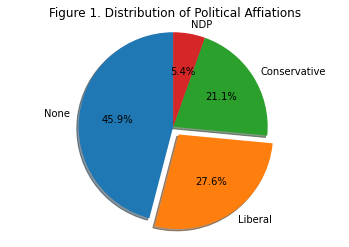

In [20]:
labels = 'None', 'Liberal', 'Conservative', 'NDP'
sizes = list(CA_elections['Political_Party'].value_counts())
explode = (0, 0.1, 0, 0)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title('Figure 1. Distribution of Political Affiations')
plt.show()

Text(0.5, 1.0, 'Figure 2. Distribution of sentiments of Each Party')

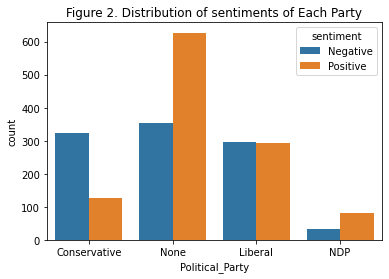

In [21]:
ax = sns.countplot(x="Political_Party", data=CA_elections,hue='sentiment')
ax.set_title('Figure 2. Distribution of sentiments of Each Party')

From figure 1 above, we can see that the code detected 45.9% None party in the CA elections dataset. This might because we used the text_clean to do the analysis, therefore most of the political key words can not be identified. However, we can still retrive information form this.  The pie chart indicated that more tweets are related to liberal party, following by conservative party, and only a small number of tweets are related to NDP.
<p>From Figure 2, we can see that for liberal party, the sentiments of the tweets are half and half, while more negative sentiments are in the consercative party tweets. NDP has the least number of tweets but it has more positive sentiments. 

### b. Visualization of the generic sentiment tweets and the CA elections tweets
In this part, i will use word cloud to explore the two dataset. The positive and negative sentiment tweet will be split from the dataframe, and generate the word cloud of each sentiments.

In [0]:
NegTweet = tweet_sentiment.loc[tweet_sentiment['sentiment'] == 'Negative']
PosTweet = tweet_sentiment.loc[tweet_sentiment['sentiment'] == 'Positive']

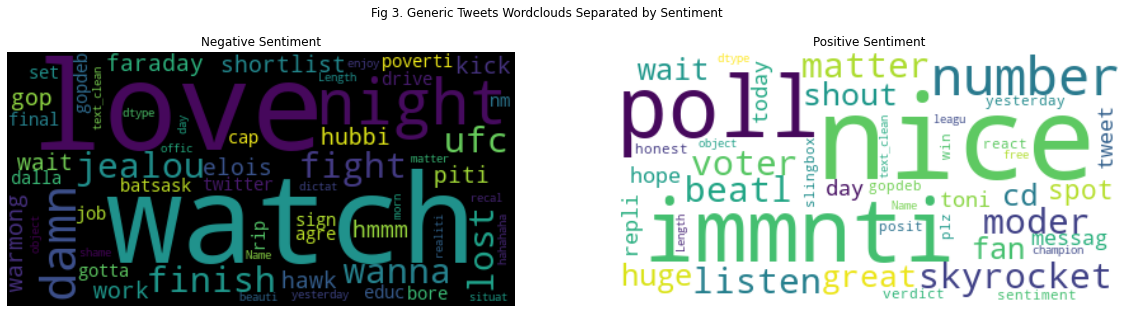

In [23]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20,5))
fig.suptitle('Fig 3. Generic Tweets Wordclouds Separated by Sentiment')

wordcloud1 = WordCloud(background_color="black").generate(str(NegTweet['text_clean']))
wordcloud2 = WordCloud(background_color="white").generate(str(PosTweet['text_clean']))

ax1.imshow(wordcloud1, interpolation='bilinear')
ax1.set(title = "Negative Sentiment")
ax2.imshow(wordcloud2, interpolation='bilinear')
ax2.set(title = "Positive Sentiment")

ax1.axis("off")
ax2.axis("off")

plt.show()

From Fig 3. We can see that for the negtive sentiments in the generic tweets, the wordcloud generated words like "Damn", "Jealous", "lost", "pity", and etc. These words clearly indicated negative sentiments. But the wordcloud also generate words like "love", this might because the twitter is tweeting negatively with positive words. 
<p>For positive sentiments, the wordclouds generated words like "nice", "greate" which nicely indicated positive sentiment. But there also are words like "yesterday", "today", "day", and etc. These words has no actual help to the sentiment analysis, we can later add those words to our stopwords.

In [0]:
NegElection = CA_elections.loc[CA_elections['sentiment'] == 'Negative']
PosElection = CA_elections.loc[CA_elections['sentiment'] == 'Positive']

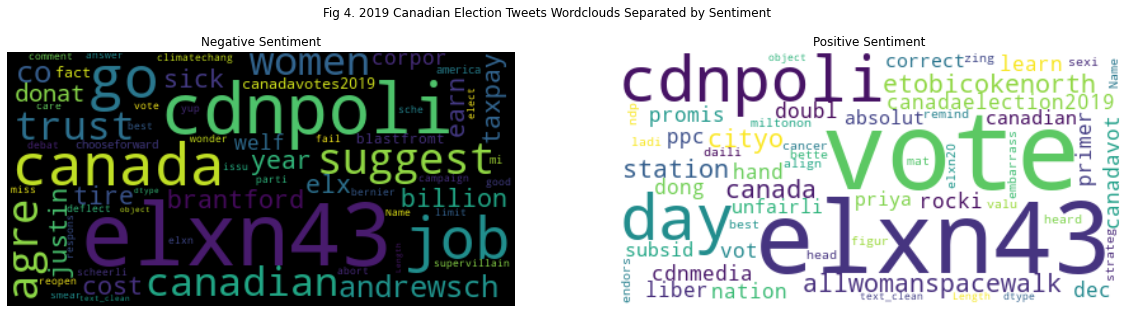

In [25]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20,5))
fig.suptitle('Fig 4. 2019 Canadian Election Tweets Wordclouds Separated by Sentiment')

wordcloud1 = WordCloud(background_color="black").generate(str(NegElection['text_clean']))
wordcloud2 = WordCloud(background_color="white").generate(str(PosElection['text_clean']))

ax1.imshow(wordcloud1, interpolation='bilinear')
ax1.set(title = "Negative Sentiment")
ax2.imshow(wordcloud2, interpolation='bilinear')
ax2.set(title = "Positive Sentiment")

ax1.axis("off")
ax2.axis("off")

plt.show()

From the word cloud above, we can see that in the negative sentiment, it appears "justin" and "andrewsch" while andre has larger font size than justin. This indicates that tweets talking about conservative has more negative sentiments than tweets talking about liberal. "Taxpay","woman" and "jobs" are in negative sentiments, whcih means they are negative due to those factors.
<P>By looking at the positive sentiment wordcloud, we can see that most of the tweets are talking about voting and this election. we could not see very clearly which political pary they are talking about.

**Bonous**: 
Next, i will keep exploraing the CA election dataset. By looking at each party's negative sentiment reason, we can see that most of the nagative reasons belonds to scandals, tell lies, and others. From this we can have a general idea that most of people would are not happy with those things, and when predicting the negative reasons for the tweets, we are more likely to get a reason of those three.  

Text(0.5, 1.0, 'Distribution of Negative Sentiments Reasons of Each Party')

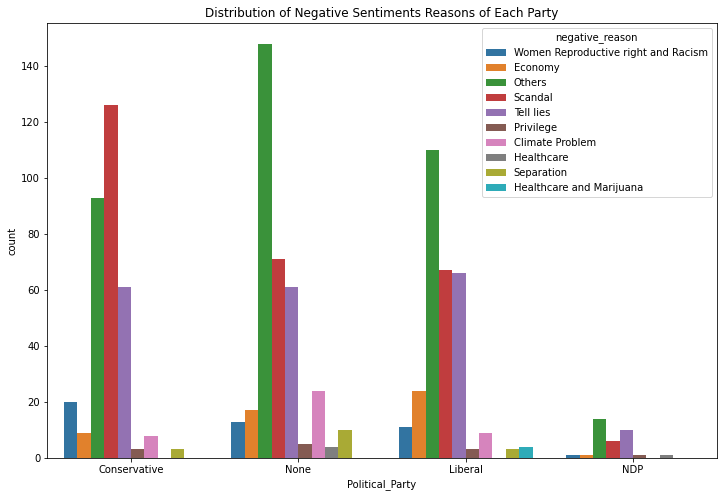

In [26]:
plt.figure(figsize = (12, 8))
ax = sns.countplot(x="Political_Party", data=CA_elections,hue='negative_reason')
ax.set_title('Distribution of Negative Sentiments Reasons of Each Party')

# 3. Model Preparation 
In this step, we will prepare the generic tweet data to try multiple classification algorithms, such as logistic regression, k-NN, Naive Bayes, SVM, decision trees, ensembles (Random Forest, XGBoost). we will also try two type of features, one is word frequency(WF), the other one is TF-IDF.
<p>The procedures of doing the model preparation are as follows:


*   Split the data into training data(70%) and test data(30%).
*   Define a function to iterate through different algorithms and tune there hyperparameters. This function will return the algorithm name and it's accuracy score.
*   Prepare the vectorizer for WF and TF-IDF



In [0]:
y = tweet_sentiment['sentiment']
X = tweet_sentiment['text_clean']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=1)

Bonous: N-Grams
<p>vect__ngram_range; here we are telling to use unigram and bigrams and choose the one which is optimal.

In [0]:
names = ["Logistic Regression", 
         "KNN", 
         "Multinomial NB",
         "SVM", 
         "Decision Trees", 
         "Random Forest", 
         "XGBoost"]

classifiers = [
    LogisticRegression(),
    KNeighborsClassifier(),
    MultinomialNB(), 
    LinearSVC(), 
    DecisionTreeClassifier(), 
    RandomForestClassifier(), 
    XGBClassifier()
]

parameters = [
              {'vect__ngram_range': [(1, 1), (1, 2)],
              'clf__C': (0.01,0.1,1)},
              {'vect__ngram_range': [(1, 1), (1, 2)],
              'clf__n_neighbors': (5,10,15)},
              {'vect__ngram_range': [(1, 1), (1, 2)],
              'clf__alpha': (1e-2, 1e-3)},
              {'vect__ngram_range': [(1, 1), (1, 2)],
              'clf__C': (np.logspace(-5, 1, 5))},
              {'vect__ngram_range': [(1, 1), (1, 2)],
              'clf__max_depth': (1, 2)},
              {'vect__ngram_range': [(1, 1), (1, 2)],
              'clf__max_depth': (1, 2)},
              {'vect__ngram_range': [(1, 1), (1, 2)],
              'clf__max_depth': (1, 2)}
             ]

In [0]:
def model_implementation(feature_type):
    algorithms = []
    scores = []
    for name, classifier, params in zip(names, classifiers, parameters):
        clf_pipe = Pipeline([
            ('vect', feature_type),
            ('clf', classifier),
        ])
        gs_clf = GridSearchCV(clf_pipe, param_grid=params, n_jobs=-1)
        clf = gs_clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        score = accuracy_score(y_pred, y_test)
        print("{} score: {}".format(name, score))
        algorithms.append(name)
        scores.append(score)
        
    return names,scores


### Word Frequency WF

In [0]:
WFvectorizer = CountVectorizer()

### Term Frequency–Inverse Document Frequency (TF-IDF)

In [0]:
TFIDFvectorizer = TfidfVectorizer()

# 4. Model Implementation


The dataset has been prepared to do model implementation. Firstly, we run the model implementation funtion with Word Frequency feature type. Next, we run the function with TF-IDF feature type. The function will print the score of each algorithm, then we will analysis the model result with the output values.
<p>(note: the function can run a long time because we are trying different algorithms, for convience, i hard coded the accuracy score. )

In [0]:
#names, WF_score = model_implementation(WFvectorizer)

#Logistic Regression score: 0.7406078724464374
#KNN score: 0.6751370204285002
#Multinomial NB score: 0.7090433482810165
#SVM score: 0.7393124065769806
#Decision Trees score: 0.5570503238664674
#Random Forest score: 0.5566766317887394
#XGBoost score: 0.6395615346287992

#hardcode score to save time
WF_score= [0.7406078724464374, 0.6751370204285002,0.7090433482810165,0.7393124065769806,0.5570503238664674,0.5566766317887394,0.6395615346287992]

In [0]:
#names, TFIDF_score= model_implementation(TFIDFvectorizer)

#Logistic Regression score: 0.7409815645241654
#KNN score: 0.6044593921275535
#Multinomial NB score: 0.7012954658694569
#SVM score: 0.7411310413552566
#Decision Trees score: 0.5571001494768311
#Random Forest score: 0.5566766317887394
#XGBoost score: 0.6380169407075237

#hardcode score to save time
TFIDF_score= [0.7409815645241654,0.6044593921275535,0.7012954658694569,0.7411310413552566,0.5571001494768311,0.5566766317887394,0.6380169407075237]

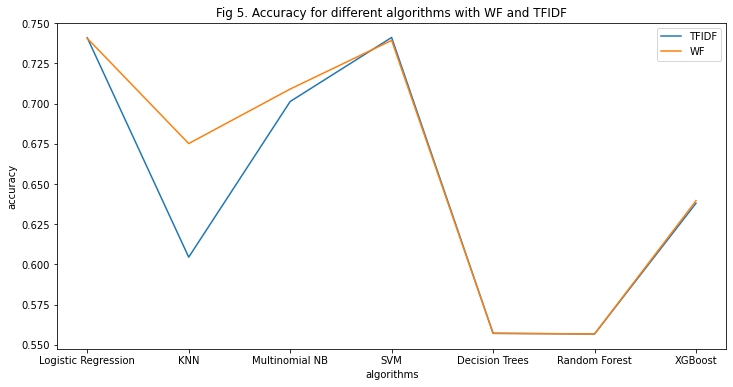

In [34]:
plt.figure(figsize=(12,6))

plt.plot(names,TFIDF_score,label = 'TFIDF')
plt.plot(names,WF_score,label = 'WF')
plt.title('Fig 5. Accuracy for different algorithms with WF and TFIDF')
plt.xlabel('algorithms')
plt.ylabel('accuracy')
plt.legend()

From Fig 5. we can see that both feature types WF and TFIDF perform better with logistic regression and SVM. Decision Trees and Random Forest has the lowest accuracy. The WF performed better with KNN than TFIDF, and the accuracies are the same with XGBoost algorithm for WF and TFIDF. From here, we conclude that Logistic regression performed the best with TFIDF, with an accuracy of xxx.

### a. Model implementation on CA election data
Next, we will use this model (logistic regression) to make predictions on the CA election data. 

In [0]:
y = CA_elections['sentiment']
X = CA_elections['text_clean']

In [36]:
clf_pipe = Pipeline([('vect', TfidfVectorizer()),
                     ('clf', LogisticRegression())])
gs_clf = GridSearchCV(clf_pipe, 
                      param_grid={'vect__ngram_range': [(1, 1), (1, 2)],
                                  'clf__C': (0.01,0.1,1)}, 
                      n_jobs=-1)
clf = gs_clf.fit(X_train, y_train)
y_pred = clf.predict(X)
score = accuracy_score(y_pred, y)
print(score)

0.6207219878105954


<b>How well do your predictions match the sentiment labelled in the 2019 Canadian elections data?</b>
<p>The CA election data with logistic model has an accuracy of 62.1%. 

### b. Visualization on different parties' prediction and true sentiment

In [0]:
CA_elections['y_pred'] = y_pred

Text(0.5, 1.0, 'Figure 6. True Sentiments of each Political Party')

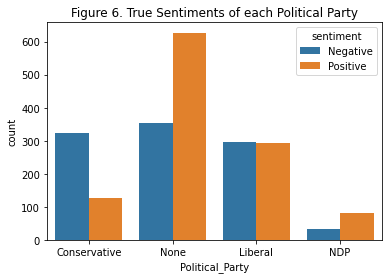

In [38]:
ax = sns.countplot(x="Political_Party", data=CA_elections,hue='sentiment')
ax.set_title('Figure 6. True Sentiments of each Political Party')

Text(0.5, 1.0, 'Figure 7. Predict Sentiments of each Political Party')

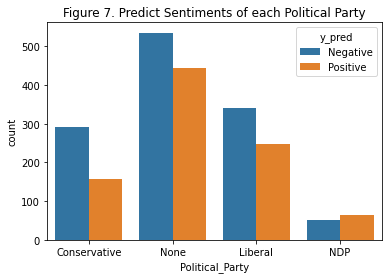

In [39]:
ax = sns.countplot(x="Political_Party", data=CA_elections,hue='y_pred')
ax.set_title('Figure 7. Predict Sentiments of each Political Party')

For the 2019 election, Liberal Party won. In this case we will look at the  voting of different parties. According to wikipedia, Liberal pary got 33.1% votes, conservative got 34.4% votes, and NDP got 15.9% votes. (Liberal party won because they had more seats)
<p>From Fig 6. above we can see that for liberal party and cpc, we predicted more negative sentiment than positive for the corrsponding CA election tweets.<p>The predictions have half half sentiments for NDP. This could mean that if the twitters all went voting, relatively more people would vote for liberal and conservative since there are more positive count in those two parties than NDP. And people would vote for liberal more. This suggestion kind of matched the actual voting distribution (people vote for cpc and lpc more). However, we falied to predict that cpc actually had more voting. 
<p><b>DISCUSSION
<p>This tells us that NLP would be part of consideration for prediction of the election outcome. It would not make very correct predictions, but the NLP analytics could tell us insights about how people see those parties. By knowing this, political parties could source the reasons why people have negative sentiments about the party and eventually do better by fixing those negative reasons. </b>

### c. Model implementation on negative CA election tweets

Next, we will implement different algorithms to negative CA election tweets. The steps are following:
* Locate the rows in the CA election dataset that has negative sentiment. 
* Count the number of differnt reasons of negative sentiments and merge some reasons together.
* Perform selected algorithms
* Compare result

In [40]:
NegElecTweet = CA_elections.loc[CA_elections['sentiment'] == 'Negative']
NegElecTweet

,sentiment,negative_reason,text,text_clean,mentioned,HashTags,Political_Party,y_pred
0,Negative,Women Reproductive right and Racism,"@RosieBarton So instead of your suggestion, ho...",suggest agre canadian women trust andrewsch co...,[rosiebarton],"[canadian, women, andrewscheer, conservatives,...",Conservative,Negative
2,Negative,Economy,#Brantford It's going to cost YOU $94 BILLION ...,brantford go cost 94 billion 4 year justin elx...,[],"[brantford, elxn43, cdnpoli, canada]",Liberal,Negative
4,Negative,Economy,#Canada #taxpayers are sick &amp; tired of hav...,canada taxpay sick tire earn donat corpor welf...,"[snclavalin, sheila_copps]","[canada, taxpayers, trudeaumustgo, canada, snc...",Liberal,Negative
5,Negative,Others,#CanadaVotes2019 #elxn43 #cdnpoli - FACTS - #B...,canadavotes2019 elxn43 cdnpoli fact blastfromt...,[],"[canadavotes2019, elxn43, cdnpoli, blastfromth...",Conservative,Negative
8,Negative,Others,"#chooseforward #cdnpoli #elxn43\nCanada, Don't...",chooseforward cdnpoli elxn43 canada america mi...,[youtube],"[chooseforward, cdnpoli, elxn43]",Liberal,Negative
...,...,...,...,...,...,...,...,...
2125,Negative,Others,You can’t be a supervillain of an election if ...,supervillain elect fail job elxn43,[],[elxn43],None,Negative
2126,Negative,Climate Problem,You care about limiting #ClimateChange and are...,care limit climatechang wonder parti vote elxn...,[khayhoe],"[climatechange, elxn43?, co2]",None,Negative
2128,Negative,Scandal,You know he was doing a good enough job smeari...,good job smear campaign cdnpoli elxn43 bernier...,[andrewscheer?],"[cdnpoli, elxn43]",None,Positive
2129,Negative,Scandal,You missed the comment. Deflecting the issue d...,miss comment deflect issu answer best respons ...,"[kinsellawarren, cpc_hq]","[cdnpoli, elxn2019, elxn43, canadavotes]",None,Negative


<b> Combine similar reasons and explaination
<p>From the .value_counts() method, we can see the number of tweets for different negative reasons. By looking into the reasons, i noticed that "healhcare" and "healcare and marijuana" are similar, so I combined this two reason together. "Economy" and "Climate Problem" can be combined as external factors because political parties could not do very much on those. "Scandal" and "Tell lies" could be combined together since those are negative reasons caused directly by the parties, i call them internal factors.

In [41]:
NegElecTweet['negative_reason'].value_counts()

Others                                 364
Scandal                                270
Tell lies                              198
Economy                                 51
Women Reproductive right and Racism     45
Climate Problem                         41
Separation                              16
Privilege                               12
Healthcare                               5
Healthcare and Marijuana                 4
Name: negative_reason, dtype: int64

In [0]:
NegElecTweet['negative_reason'] = NegElecTweet['negative_reason'].map({'Healthcare and Marijuana':'Healthcare',
                                                                       'Healthcare':'Healthcare',
                                                                       'Economy':'External factors',
                                                                       'Climate Problem': 'External factors',
                                                                       'Others':'Others',
                                                                       'Scandal':'Internal Factors',
                                                                       'Tell lies':'Internal Factors',
                                                                       'Women Reproductive right and Racism':'Women Reproductive right and Racism',
                                                                       'Separation':'Separation',
                                                                       'Privilege':'Privilege'})

In [43]:
NegElecTweet['negative_reason'].value_counts()

Internal Factors                       468
Others                                 364
External factors                        92
Women Reproductive right and Racism     45
Separation                              16
Privilege                               12
Healthcare                               9
Name: negative_reason, dtype: int64

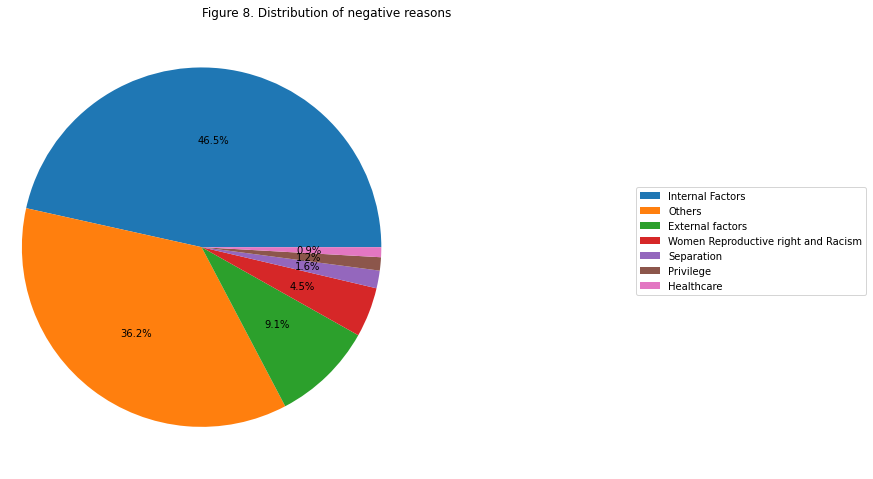

In [44]:
plt.figure(figsize = (12, 8))

title = plt.title('Figure 8. Distribution of negative reasons')
title.set_ha("left")
total = list(NegElecTweet['negative_reason'].value_counts())
plt.gca().axis("equal")
pie = plt.pie(total, startangle=0, autopct='%1.1f%%')
labels = ['Internal Factors', 'Others', 'External factors', 'Women Reproductive right and Racism','Separation','Privilege','Healthcare']
plt.legend(pie[0],labels, bbox_to_anchor=(1,0.5), loc="center right", fontsize=10, 
           bbox_transform=plt.gcf().transFigure)
plt.subplots_adjust(left=0.0, bottom=0.1, right=0.45)

Next, i will implement the models to the negative CA election data. From previous part, we know that logistic regression, SVM, and NB performed better at the generic tweet data. For the negative CA election data, I choose Logistic regression, SVM and Naive Bayes to perform the multi-class classification. The name of each classifier and its parameters has been coded below, the N-gram also used here. 

In [0]:
names = ["Logistic Regression", 
         "Multinomial NB",
         "SVM"]

classifiers = [
    LogisticRegression(multi_class='multinomial', solver='newton-cg'),
    MultinomialNB(), 
    LinearSVC()
]

parameters = [{'vect__ngram_range': [(1, 1), (1, 2)],
              'clf__C': (0.01,0.1,1)},
              {'vect__ngram_range': [(1, 1), (1, 2)],
              'clf__alpha': (1e-2, 1e-3)},
              {'vect__ngram_range': [(1, 1), (1, 2)],
              'clf__C': (np.logspace(-5, 1, 5))}]

In [0]:
X = NegElecTweet['text_clean']
y = NegElecTweet['negative_reason']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=1)


def model_implementation():
    algorithms = []
    scores = []
    for name, classifier, params in zip(names, classifiers, parameters):
        clf_pipe = Pipeline([
            ('vect', TfidfVectorizer()),
            ('clf', classifier),
        ])
        gs_clf = GridSearchCV(clf_pipe, param_grid=params, n_jobs=-1)
        clf = gs_clf.fit(X_train, y_train)
        y_prediction = clf.predict(X_test)
        score = accuracy_score(y_prediction, y_test)
        print("{} score: {}".format(name, score))
        algorithms.append(name)
        scores.append(score)       
    return names,scores

In [47]:
names,accuracy = model_implementation()

Logistic Regression score: 0.5794701986754967
Multinomial NB score: 0.5463576158940397
SVM score: 0.5629139072847682


Finally, we printed out the accuracy of each algorithm for the negative sentiment data. 

# 5. Result
### a. Discussion on First model
* Describe the results of the analysis and discuss your interpretation of the results.
    * The first model use logistic regression with CA election data. The returned accuracy of the model is 60.4%. From the figures plotted with this model, we can see the prediction sentiments and the true sentiments for the CA election data. By compare the true and prediction sentiments, we can see that conservation party's prediction has higher accuracy as the counts of the neg and pos sentiments are similar. The model predict more negative sentiments for cpc and NDP, as well as tweets about none party. Those tweets has lower accuracy which influenced the overall performance.

* Explain how each party is viewed in the public eye based on the sentiment value.
    * For liberal party, there are half negative and half positive sentiment tweets. This could mean that if those twitters went voting, half of them would vote for liberal.
    * For conservative party, there are more than twice more negative sentiments than positive. In public eyes, people would not like conservative party lead canada (at least majority of them). 
    * For NDP, people are having more positive sentiments. Although the number of tweets talking about NDP are not large, the public view NDP as a good party. This might indicate that if people starting to care about NDP more, or NDP gain more public attention, this party would receieve positive sentiments.

### b. Second model
* Based on the model that worked best, provide a few reasons why your model may
fail to predict the correct negative reasons.
    * Based on the model result, the SVM worked best with an accuracy of 57.3%.3%, while Logistic regression and NB have accuracies of 52.6% and 47.7% respectively.
    * Some of the reasons of why the model fail to predict the correct negative reasons are:
        * We don't have enough datapoints for certain negative reasons, such as external factors(economy, climate)
        * the tweet does not contain the word that indicate the specific negative reason but if we read the tweet in sentence, it should be belong to a negative reason.
        * Imbalanced datapoints, we have a lot of internal factor reasons(tell lies, scandel) and others, this also makes the prediction failure. 
* Examples: 
    * NegElection['text'][1093] = '“This is the most reckless rhetoric of any Canadian leader in the past 50 or 60 years. It is separatist rhetoric, in that it invokes the citizens of one province to tame or nullify the valid concerns of the citizens of another province.” #elxn43 https://t.co/J7btla3019'
    * The true negative reason is separation, however the model predicted as 'internal factors'
    * This shows we have an inbalanced data, negative reasons like "seperation" does not have enough training data, which cause the model failed to capture the keywords and make the wrong prediction.


### c. For both models, suggest one way you can improve the accuracy of your models.
* In the data cleaning process, we used poterstemmer, which is kind of an agressive stemming process, and often includes the removal of derivational affixes. We could try to use Lemmatization to keep proper dictionary words.
* Gather more data with all kinds of negative reasons, so our model could get training on them and make better prediction.
* Better define the stop words, in the data cleaning process, I just used the stopwords.txt file provided from this course. I could further look into them and modified the stopwords in order to keep useful words and remove other unuseful words.
